In [152]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,8)

In [93]:
spark = SparkSession.builder.getOrCreate()
imdb_titles = spark.read.option("sep", "\t").option("header","true").csv("hdfs://namenode:9000/data/imdb/akas.tsv")
imdb_rating = spark.read.option("sep", "\t").option("header","true").csv("hdfs://namenode:9000/data/imdb/data.tsv")
imdb_basics = spark.read.option("sep", "\t").option("header","true").csv("hdfs://namenode:9000/data/imdb/basics.tsv")

imdb = imdb_rating.select(F.col("tconst").alias("rat_tconst"), F.col("averageRating")) \
.join(imdb_titles.select(F.col("titleId"), F.col("title").alias("t_title")), F.col("rat_tconst") == F.col("titleId")) \
.join(imdb_basics.select(F.col("tconst").alias("bas_tconst"), F.col("startYear"), F.col("genres")), F.col("rat_tconst") == F.col("bas_tconst"))

In [31]:
chemin_movies = "./data/Movies/"

In [32]:
schema = StructType([
    StructField("show_id", StringType(), True),
    StructField("type", StringType(), True),
    StructField("title", StringType(), True),
    StructField("director", StringType(), True),
    StructField("cast", StringType(), True),
    StructField("country", StringType(), True),
    StructField("date_added", StringType(), True),
    StructField("release_year", StringType(), True),
    StructField("rating", StringType(), True),
    StructField("duration", StringType(), True),
    StructField("listed_in", StringType(), True),
    StructField("description", StringType(), True)])

## Début du Batch

In [166]:
movies = spark.read.csv(chemin_movies, header=False, schema=schema)

In [167]:
movies.count()

1918

In [164]:
imdb_titles.count()

19549634

In [165]:
imdb_rating.count()

993821

In [94]:
imdb.printSchema()

root
 |-- rat_tconst: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- titleId: string (nullable = true)
 |-- t_title: string (nullable = true)
 |-- bas_tconst: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- genres: string (nullable = true)



In [102]:
movies_imdb = movies.join(imdb, (movies.title == imdb.t_title) & (movies.release_year == imdb.startYear), how="inner")

In [96]:
movies_imdb.count()

3080

In [168]:
movies.show(vertical=True)

-RECORD 0----------------------------
 show_id      | s1                   
 type         | TV Show              
 title        | 3%                   
 director     | null                 
 cast         | João Miguel, Bian... 
 country      | Brazil               
 date_added   | August 14, 2020      
 release_year | 2020                 
 rating       | TV-MA                
 duration     | 4 Seasons            
 listed_in    | International TV ... 
 description  | In a future where... 
-RECORD 1----------------------------
 show_id      | s2                   
 type         | Movie                
 title        | 7:19                 
 director     | Jorge Michel Grau    
 cast         | Demián Bichir, Hé... 
 country      | Mexico               
 date_added   | December 23, 2016    
 release_year | 2016                 
 rating       | TV-MA                
 duration     | 93 min               
 listed_in    | Dramas, Internati... 
 description  | After a devastati... 
-RECORD 2---

In [97]:
movies_imdb.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)
 |-- rat_tconst: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- titleId: string (nullable = true)
 |-- t_title: string (nullable = true)
 |-- bas_tconst: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- genres: string (nullable = true)



In [103]:
movies_imdb = movies_imdb.dropDuplicates(subset=['title', 'startYear'])

In [107]:
# Nombre de films/series récupérées 
print ("il y a " + str(movies_imdb.count()) + " films et series")

il y a 1041 films en bdd


In [110]:
# Les Films tournés après 2010
movies_imdb.filter((movies_imdb.type == 'Movie') & (movies_imdb.release_year > 2010)).count()

652

In [112]:
# Les pays qui produit le plus de Films 
movies_imdb.groupBy('country').count().sort(F.desc("count")).show(3)

+--------------+-----+
|       country|count|
+--------------+-----+
| United States|  363|
|         India|  160|
|United Kingdom|   45|
+--------------+-----+
only showing top 3 rows



In [113]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
@udf(returnType = IntegerType())
def remove_min(duration):
    return int(duration.replace("min", ""))

@udf(returnType = IntegerType())
def remove_season(duration):
    splitedStr = duration.split()
    return int(splitedStr[0])

In [116]:
# La durée moyenne des Films américains
us_movies = movies_imdb.filter( (movies_imdb.country == 'United States') & (movies_imdb.type == 'Movie') )
us_movie_formated = us_movies.withColumn("duration_int", remove_min(F.col("duration")))
duration_average  = us_movie_formated.agg({"duration_int": "avg"}).collect()
strg = str(duration_average).split("=")
print("La durée moyenne des films Américains est de " + str(strg[1].replace(")]", "")) + " minutes")

La durée moyenne des films Américains est de 91.36792452830188 minutes


In [117]:
# Le nombre moyen de saison par série du catalogue Netflix
tv_shows = movies_imdb.filter(movies_imdb.type == 'TV Show')
tv_shows_formated = tv_shows.withColumn("season_int", remove_season(F.col("duration")))
season_average  = tv_shows_formated.agg({"season_int": "avg"}).collect()
strg = str(season_average).split("=")
print("Le nombre moyen de saison par sériee tv est de " + strg[1].replace(")]", "") + " dans le catalogue Netflix")

Le nombre moyen de saison par sériee tv est de 1.2458100558659218 dans le catalogue Netflix


In [119]:
# min max des duration
us_movie_formated.groupBy("country").agg(F.min("duration_int"), F.max("duration_int")).show()

+-------------+-----------------+-----------------+
|      country|min(duration_int)|max(duration_int)|
+-------------+-----------------+-----------------+
|United States|               24|              312|
+-------------+-----------------+-----------------+



In [120]:
only_movies = movies_imdb.filter(movies_imdb.type == 'Movie')
only_series = movies_imdb.filter(movies_imdb.type == 'TV Show')

In [121]:
only_movies = only_movies.withColumn("duration_int", remove_min(F.col("duration")))
only_series = only_series.withColumn("season_int", remove_season(F.col("duration")))

In [147]:
p1 = only_series.groupBy("country").agg(F.max("season_int")).sort(F.desc("max(season_int)"))
pd1 = p1.toPandas()

<AxesSubplot:xlabel='country'>

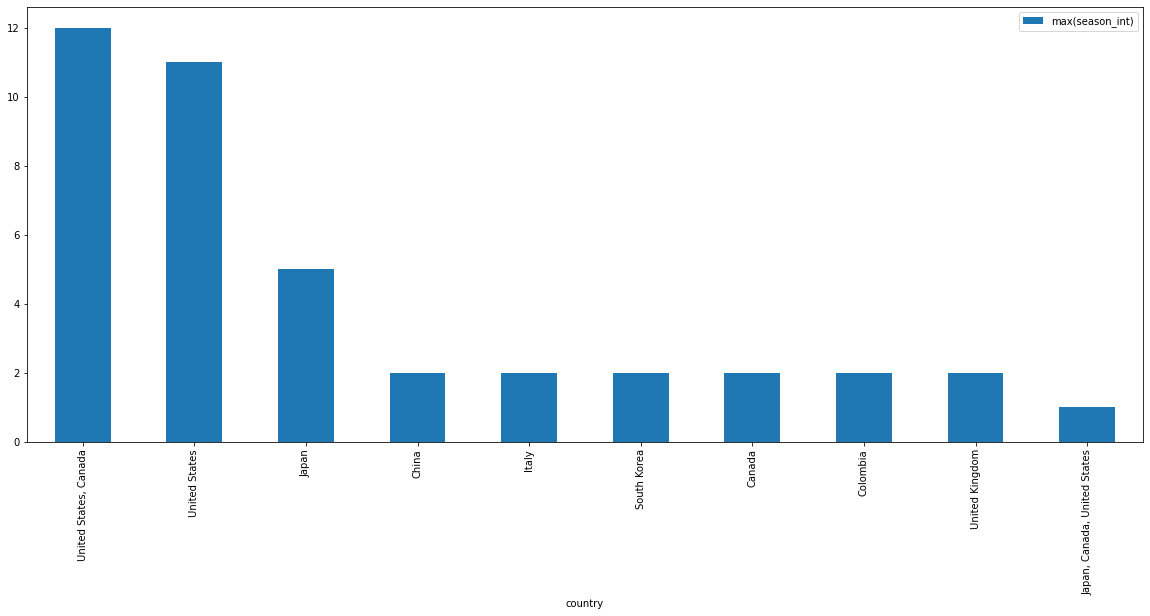

In [154]:
# pays qui font des series avec trop de saisons
pd1.iloc[0:10].plot.bar(x="country")

In [124]:
only_movies.groupBy("country").agg(F.min("duration_int"), F.max("duration_int")).show()

+--------------------+-----------------+-----------------+
|             country|min(duration_int)|max(duration_int)|
+--------------------+-----------------+-----------------+
|      India, Germany|              104|              104|
|  Philippines, Qatar|              115|              115|
|Hong Kong, China,...|              113|              113|
|  Germany, Sri Lanka|               87|               87|
|Brazil, France, G...|              130|              130|
|Turkey, United St...|              112|              112|
|United Kingdom, C...|              100|              100|
|       Turkey, India|              107|              107|
|     France, Belgium|               81|              112|
|         Philippines|              103|              132|
|United States, Au...|               81|               81|
|China, United States|              101|              101|
|Argentina, Brazil...|               96|               96|
|           Singapore|               78|               7

In [142]:
p2 = only_movies.groupBy("country").count().sort(F.desc("count"))
pd2 = p2.toPandas()

<AxesSubplot:xlabel='country'>

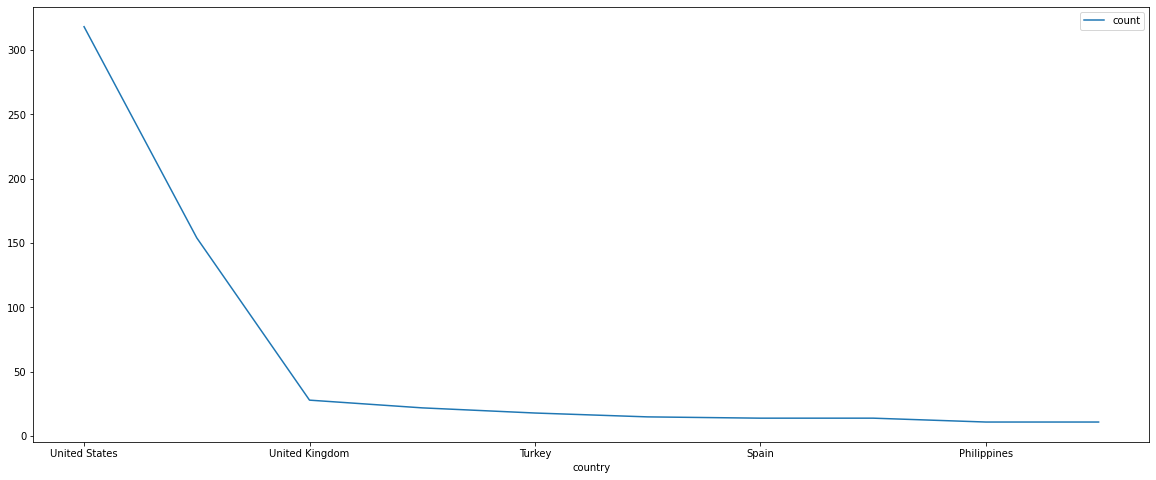

In [153]:
pd2.iloc[0:10].plot.line(x="country", y="count")

In [162]:
only_movies.groupBy("title").agg(F.max("averageRating")).sort(F.desc("max(averageRating)")).show(10)

+--------------------+------------------+
|               title|max(averageRating)|
+--------------------+------------------+
|Care of Kancharap...|               9.1|
|          Death Note|               8.8|
|               Ayana|               8.8|
|         Be Here Now|               8.7|
|Bill Hicks: Relen...|               8.7|
|              Desire|               8.6|
|         City of God|               8.6|
|Bill Hicks: Revel...|               8.6|
|  American History X|               8.5|
|Dave Chappelle: S...|               8.5|
+--------------------+------------------+
only showing top 10 rows



In [163]:
only_series.groupBy("title").agg(F.max("averageRating")).sort(F.desc("max(averageRating)")).show(10)

+--------------------+------------------+
|               title|max(averageRating)|
+--------------------+------------------+
|      Blue Planet II|               9.4|
|     College Romance|               9.2|
|              Africa|               9.0|
|     Attack on Titan|               8.8|
|      Dave Chappelle|               8.7|
|         Brotherhood|               8.7|
| A Lion in the House|               8.7|
|       Ashes of Love|               8.5|
|A Little Thing Ca...|               8.5|
|         Delhi Crime|               8.5|
+--------------------+------------------+
only showing top 10 rows

